# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.5040],
         [-1.2786]]),
 tensor([[ 1.0000e+00,  1.5040e+00,  1.1310e+00,  5.6698e-01,  2.1318e-01,
           6.4123e-02,  1.6073e-02,  3.4534e-03,  6.4922e-04,  1.0849e-04,
           1.6317e-05,  2.2309e-06,  2.7960e-07,  3.2347e-08,  3.4749e-09,
           3.4841e-10,  3.2750e-11,  2.8973e-12,  2.4208e-13,  1.9162e-14],
         [ 1.0000e+00, -1.2786e+00,  8.1744e-01, -3.4840e-01,  1.1137e-01,
          -2.8479e-02,  6.0691e-03, -1.1086e-03,  1.7718e-04, -2.5172e-05,
           3.2186e-06, -3.7412e-07,  3.9863e-08, -3.9208e-09,  3.5808e-10,
          -3.0524e-11,  2.4393e-12, -1.8347e-13,  1.3032e-14, -8.7703e-16]]),
 tensor([ 6.1117, -1.3252]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 5.000155   1.2050662 -3.4104288  5.6214323]]


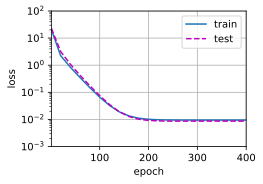

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.6163676 3.4193   ]]


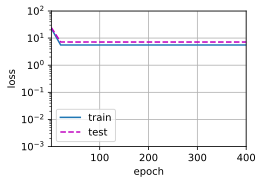

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.97304821e+00  1.24102914e+00 -3.25519848e+00  5.39101648e+00
  -5.27919888e-01  9.29646790e-01  3.26363631e-02 -6.45345971e-02
   1.24137320e-01 -2.71928627e-02 -1.68626353e-01 -4.83876131e-02
  -1.06175303e-01 -9.12119225e-02  1.27102241e-01 -1.00051455e-01
  -2.09578015e-02  3.74252535e-03  9.93338302e-02 -2.03188375e-01]]


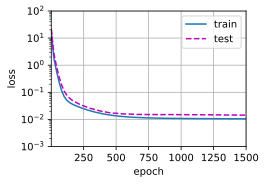

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)